# Document Vectors and Visualization

### Initial setup things

In [10]:
!conda install --file ../requirements.txt -y

Solving environment: done

## Package Plan ##

  environment location: /anaconda3

  added / updated specs:
    - gensim==3.4.0
    - matplotlib==2.2.2
    - numpy==1.14.3
    - scikit-learn
    - spacy==2.0.12


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.6.14               |           py36_0         2.1 MB
    ------------------------------------------------------------
                                           Total:         2.1 MB

The following packages will be UPDATED:

  conda                                       4.6.12-py36_1 --> 4.6.14-py36_0



conda-4.6.14         | 2.1 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


## Word Vectors

Upload `datafile.json` and `requirements.txt` then install requirements; don't run this block unless you need to (it takes a while).

Now that the necessary files are uploaded, load the necessary packages. If the word embeddings aren't loaded yet, install them (this also takes a long time, but this code should check if it's necessary).

In [12]:
import sys
import json
import re
import spacy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
import numpy
import matplotlib.pyplot as plt
import random


try:
    open("project_summaries.json", "r")
except FileNotFoundError as fnfe:
    print("Upload the data file. (See the above block)")
with open("project_summaries.json", "r") as datafile:
    DATASET = json.load(datafile)
random.shuffle(DATASET)  # shuffle the dataset to better train vectors

try:
    import en_core_web_lg
except ModuleNotFoundError as mnfe:
    !python -m spacy download en_core_web_lg
    import en_core_web_lg
finally:
    EMBEDDING = en_core_web_lg.load()

Define functions needed to process data into vectors. Also define `N`, the number of records to use.

In [13]:
N = 500

def download_dataset():
    DATASET = dynamo_db.get_dataset("project_summaries")
    for doc in DATASET:
        doc["_id"] = int(doc["_id"])
    with open("datafile.json", "w") as datafile:
        json.dump(DATASET, datafile)


def get_words(text):
    """
    thanks jackie
    """
    text = text.lower()
    wordlist = text.split()
    clean_list = []
    for word in wordlist:
        # only get words (no digits)
        if not word.isdigit() and not re.match(r"[^\w]", word):
            clean_list.append(word)
    return " ".join(clean_list)


def naive_doc_vectors():
    return [
        EMBEDDING(remove_stopwords(get_words(doc["summary"]))).vector
        for doc in DATASET[: N - 1]
    ]


def vector_labels():
    return [doc["theme"] for doc in DATASET[: N - 1]]


def construct_reduced_X(vectors):
    X = numpy.vstack(vectors)
    scaler = StandardScaler()
    scaler.fit_transform(X)
    ev = PCA().fit(X).explained_variance_ratio_
    pca = PCA(n_components=2)
    pca.fit_transform(X)
    return X, ev

In [15]:
    # get word embeddings
    vectors = naive_doc_vectors()

    # construct feature matrix reduced with PCA
    X, ev = construct_reduced_X(vectors)

Visualize the results of adding word vectors to describe documents.

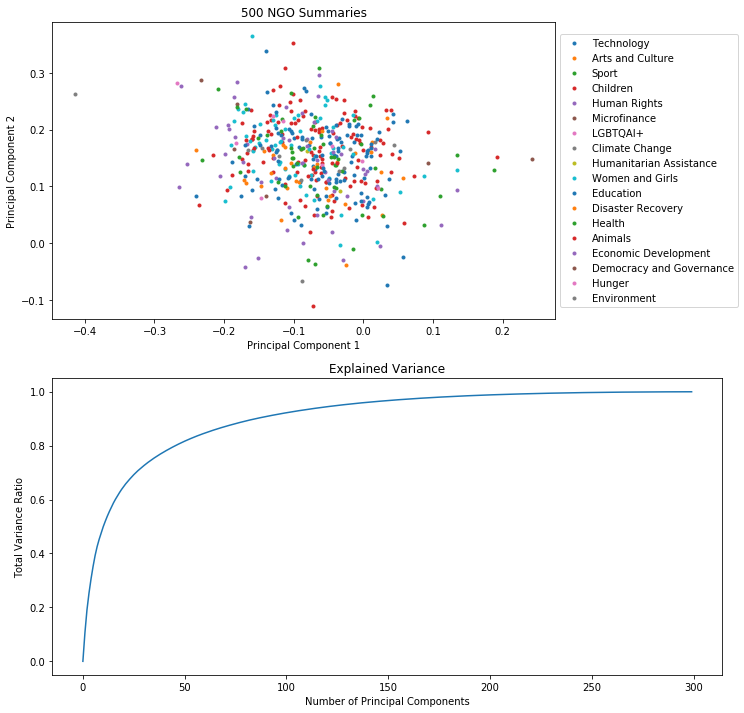

In [16]:
    labels = numpy.array(vector_labels())
    fig, ax = plt.subplots(2)
    labelset = set(labels)
    for label in labelset:
        ax[0].plot(
            X[labels == label, 0],
            X[labels == label, 1],
            label=label,
            marker=".",
            linestyle="",
        )
    ax[0].set_title("{} NGO Summaries".format(N))
    ax[0].set_xlabel("Principal Component 1")
    box = ax[0].get_position()
    ax[0].set_position([box.x0, box.y0, box.width * 0.75, box.height])
    ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[0].set_ylabel("Principal Component 2")
#     print([numpy.sum(ev[:n]) for n in range(10)])  # print explained variance values
    ax[1].plot([numpy.sum(ev[:n]) for n in range(len(ev))])
    ax[1].set_title("Explained Variance")
    ax[1].set_xlabel("Number of Principal Components")
    ax[1].set_ylabel("Total Variance Ratio")
    fig.set_size_inches(12, 12)

This isn't the most clear plot; the projection of the word vectors from their 300-dimensional space to this 2-dimensional visualization does not give any obvious indication of how an organization's assigned label influences where its summative word vector falls.

## Document Vectors

`get_documents()`: Get all documents out of the dataset. When processing them, remove stopwords, stem, and lemmatize using the generic Gensim function which does most of those things.

`train_doc2vec()`: This provides all of the documents to `Doc2Vec()` for training. When on Colab, we can use a high number of workers as the processing is done 

In [17]:
import os
import gensim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Doc2Vec

LabeledSentence = gensim.models.doc2vec.TaggedDocument

def get_documents():
  documents = []
  for id, doc in enumerate(DATASET):
    document = preprocess_string(remove_stopwords(get_words(doc["summary"])))
    documents.append(LabeledSentence(document, [id]))
  return documents


def train_doc2vec(documents):
  model = Doc2Vec(documents, vector_size=100, window=10, min_count=500, workers=12, dm=1, alpha=0.025, min_alpha=0.001)
  model.train(documents, total_examples=model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)
  return model

In [18]:
documents = get_documents()
model = train_doc2vec(documents)

### Cluster using K-means
Cluster all of the document vectors. We've found that the optimal number of clusters (balancing completeness and specificity) is 14.

In [19]:
N_CLUSTERS = 14

def cluster_kmeans(model):
  kmeans_model = KMeans(n_clusters=N_CLUSTERS)
  X = kmeans_model.fit(model.docvecs.vectors_docs)
  labels=kmeans_model.labels_.tolist()
  l = kmeans_model.fit_predict(model.docvecs.vectors_docs)
  return labels, kmeans_model


labels, kmeans_model = cluster_kmeans(model)

Reduce the document vectors to 2 dimensions using PCA. Label each document using the K-means determined cluster label.

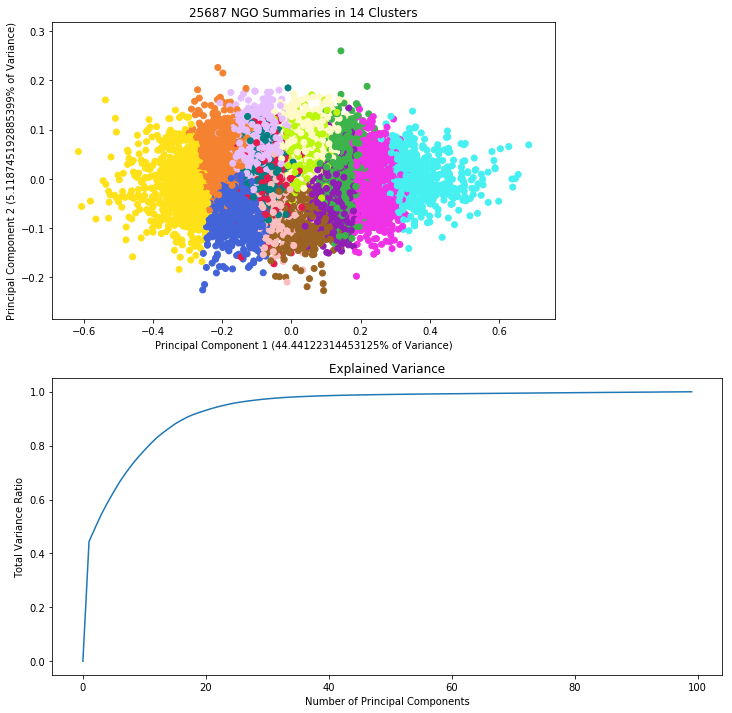

In [20]:
ev = PCA().fit(model.docvecs.vectors_docs).explained_variance_ratio_  # get the explained variance before reducing
# StandardScaler.fit_transform(model.docvecs.vectors_docs)
datapoint = PCA(n_components=2).fit_transform(model.docvecs.vectors_docs)

fig, ax = plt.subplots(2)

# this is a list of 20 somewhat distinct colors to draw from
label1 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
color = [label1[i % 20] for i in labels]

# make a scatterplot of all summaries, and 
ax[0].scatter(datapoint[:, 0], datapoint[:, 1], c=color)
ax[0].set_title("{} NGO Summaries in {} Clusters".format(len(DATASET), N_CLUSTERS))
ax[0].set_xlabel("Principal Component 1 ({}% of Variance)".format(ev[0] * 100))
box = ax[0].get_position()
ax[0].set_position([box.x0, box.y0, box.width * 0.75, box.height])
# ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].set_ylabel("Principal Component 2 ({}% of Variance)".format(ev[1] * 100))
ax[1].plot([numpy.sum(ev[:n]) for n in range(len(ev))])
ax[1].set_title("Explained Variance")
ax[1].set_xlabel("Number of Principal Components")
ax[1].set_ylabel("Total Variance Ratio")
fig.set_size_inches(12, 12)

Inspect the centroids of each cluster. We can do this inside our model by finding the words with vectors most similar to the vector of the centroid. These words can then be inspected here.

In [21]:
centroids = kmeans_model.cluster_centers_
from pprint import pprint
pprint([model.wv.similar_by_vector(centroid, topn=10) for centroid in centroids])

[[('gender', 0.3149259686470032),
  ('sexual', 0.29315799474716187),
  ('marriag', 0.2586212158203125),
  ('violenc', 0.2301056683063507),
  ('adolesc', 0.20133724808692932),
  ('traffick', 0.20017091929912567),
  ('abus', 0.14883935451507568),
  ('right', 0.11280287802219391),
  ('victim', 0.09421708434820175),
  ('empower', 0.09044578671455383)],
 [('flood', -0.0658319965004921),
  ('relief', -0.068355031311512),
  ('anim', -0.09045016765594482),
  ('disast', -0.09931699186563492),
  ('emerg', -0.13043521344661713),
  ('rescu', -0.15082448720932007),
  ('earthquak', -0.15601778030395508),
  ('death', -0.16916826367378235),
  ('million', -0.17878864705562592),
  ('hospit', -0.1939803808927536)],
 [('class', 0.7152177691459656),
  ('english', 0.7023009657859802),
  ('academ', 0.7003851532936096),
  ('student', 0.6667205095291138),
  ('secondari', 0.6619374752044678),
  ('classroom', 0.6196337938308716),
  ('studi', 0.6038830280303955),
  ('scholarship', 0.6025466918945312),
  ('colleg'

### Cluster Using Agglomerative Hierarchical Clustering

This method forms clusters by progressively grouping datapoints together based on a distance metric; in our case, we are using document vectors, so it is most appropriate to minimize the cosine of the angle between vectors. Update: I switched to using euclidean distance as an affinity metric as it enables "ward linkage" (not entirely sure what this is), and it apparently minimizes the variance inside clusters as an attempt to avoid ending up with one giant cluster and \(N - 1\) small clusters.

In [22]:
from sklearn.cluster import AgglomerativeClustering

def cluster_agglomerative(model):
  agglomerative_model = AgglomerativeClustering(n_clusters=N_CLUSTERS, memory="./")
  X = agglomerative_model.fit(model.docvecs.vectors_docs)
  labels=agglomerative_model.labels_.tolist()
  l = agglomerative_model.fit_predict(model.docvecs.vectors_docs)
  return labels, agglomerative_model

documents = get_documents()
model = train_doc2vec(documents)
labels, agglomerative_model = cluster_agglomerative(model)

Plot again, this time using the clusters from the agglomerative model.

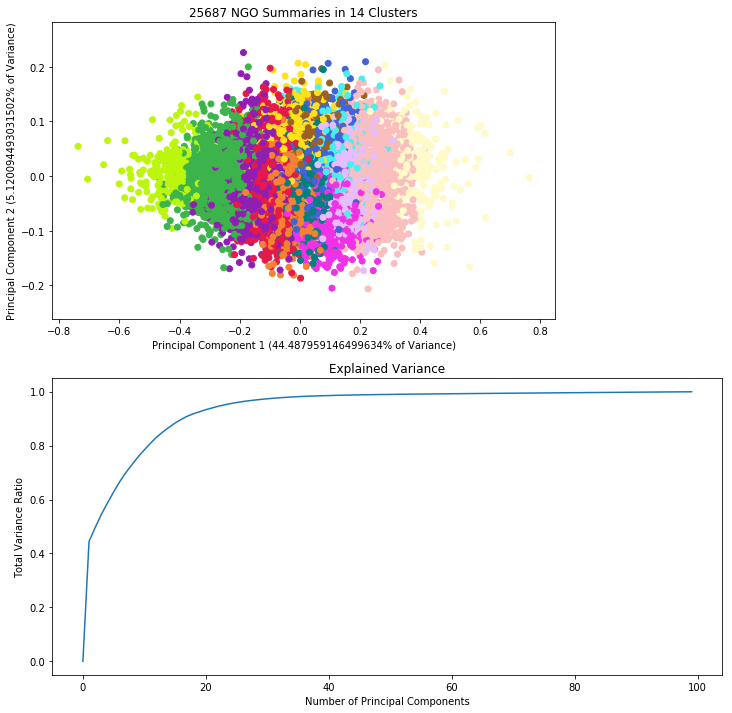

In [23]:
ev = PCA().fit(model.docvecs.vectors_docs).explained_variance_ratio_  # get the explained variance before reducing
datapoint = PCA(n_components=2).fit_transform(model.docvecs.vectors_docs)

fig, ax = plt.subplots(2)

# this is a list of 20 somewhat distinct colors to draw from
label1 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
color = [label1[i] for i in labels]

# make a scatterplot of all summaries, and 
ax[0].scatter(datapoint[:, 0], datapoint[:, 1], c=color)
ax[0].set_title("{} NGO Summaries in {} Clusters".format(len(DATASET), N_CLUSTERS))
ax[0].set_xlabel("Principal Component 1 ({}% of Variance)".format(ev[0] * 100))
box = ax[0].get_position()
ax[0].set_position([box.x0, box.y0, box.width * 0.75, box.height])
# ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].set_ylabel("Principal Component 2 ({}% of Variance)".format(ev[1] * 100))
ax[1].plot([numpy.sum(ev[:n]) for n in range(len(ev))])
ax[1].set_title("Explained Variance")
ax[1].set_xlabel("Number of Principal Components")
ax[1].set_ylabel("Total Variance Ratio")
fig.set_size_inches(12, 12)

#### As far as classification . . .
Agglomerative constructs clusters which are far more interwoven than k-means. It is unclear how the accuracy of clusters compares to those in k-means. Given that clusters are essentially just a cross-section of a level-order traversal of a relationship tree, the clusters don't really have inherent centroids as they do in d-means, though we could calculate these and compare them to those found through k means. This still might not be worth pursuing, though, as it might be impractical to build a classifier based on agglomerative hierarchical clustering (I now see why Nick was hesitant for us to use this).

#### But we can still take advantage of this method:
Because agglomerative clustering draws relationships between datapoints, we might be able to gain some insight from inspecting the dendrogram produced by clustering.